**Importing libraries**

In [1]:
import boto3
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
from math import pi
import pandas as pd
import numpy as np
import spacy
import youtube_dl


In [2]:
os.chdir("<CHOOSE_YOUR_FOLDER>")

**Setting up the links for the speeches in a dictionary**

In [3]:
dict_url_youtube = {'obama':'https://www.youtube.com/watch?v=ZNYmK19-d0U',\
                   'trump':'https://www.youtube.com/watch?v=Q6YvsrGILrw'}

**Downloading speeches**

In [ ]:

for url in list(dict_url_youtube.values()):
    print(f'Downloading audio file from the youtube: {url}')
    os.system(f'youtube-dl -x --audio-format mp3 {url}')

**Setting up the dataframe for the analyis**

In [4]:
df = pd.DataFrame.from_dict(dict_url_youtube, orient='index', columns=['youtube_url'])

**Linking the urls to the downloaded audio file**

In [6]:
for audio in os.listdir():
    if "obama" in audio.lower():
        df.at["obama", "filename"] = audio
    elif "trump" in audio.lower():
        df.at["trump", "filename"] = audio

**Logging in AWS**

In [8]:
aws_access_key_id = '<ACCESS_KEY>'
aws_secret_access_key = '<SECRET_KEY>'
region_name = 'eu-west-1'

In [9]:
#opening session in AWS
session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key,
                                region_name=region_name)

In [10]:
# Uploading files to S3
# Instantiate client
s3 = session.client('s3')

# List created buckets
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]

for bucket in buckets:
    print(bucket)

129035
1901321-hw
1902120
1902224
1902522-hw2
1902727
1902994
1902994-liyue
1903221-hw2
1903282
1904041
1904164-hw2-s3
1904185
1904320
1904320-mt2
1904415-lorant
1904416
aytaj-ahmad-hw2
ceu-1701281
ceu-1901272
ceu-1902213
ceu-2727
ceu-aytaj-ahmad
ceu-celia-inclass
ceu-class-alex-hip
ceu-class-zoltan-zac
ceu-class-zoltan0lt
ceu-eszter-balogh
ceu-geroldcsendes
ceu-gulyas-attila
ceu-hassaan
ceu-kissgyula
ceu-ksenia-skirpichnikova
ceu-ksenia-skirpichnikova-yag
ceu-lealoscar
ceu-miklosbona
ceu-palotai-veronika
ceu-riaz
ceu-somkuti
ceu-student-1803551
ceu-szekelygergo
ceu-tamas
ceu-vaivodaite-agne
ceu-zoltan
ceu-zoltan-inclass
cloudtrail-ceu-2019
lisasceubucket
liyue-1902994
manila-saroyan-homework
sebair-selmani-1803425
spainvideo
teodoro.criscione
yaoyu-ceu


**Upload audio files to AWS**

In [11]:
my_bucket_name='<YOUR_BUCKET_NAME>'

In [12]:
#upload files in AWS
for audio in df.filename.values:
    print(audio)
    s3.upload_file(audio,my_bucket_name,audio)

President Obama on Death of Osama bin Laden-ZNYmK19-d0U.mp3
President Trump's full announcement on the death of Abu Bakr al-Baghdadi-Q6YvsrGILrw.mp3


**Getting the AWS url location in the dataframe**

In [13]:
for index, row in df.iterrows():
    bucket_location = s3.get_bucket_location(Bucket=my_bucket_name)
    bucket_url=f"https://{my_bucket_name}.s3.amazonaws.com/{row['filename'].replace(' ', '+')}"
    df.at[index, 'aws_url']=bucket_url

**Amazon Transcribe**

In [14]:
# Function to start Amazon Transcribe job
def start_transcription(bucket, job_name, file_url, wait_process=True):
    client_transcribe = session.client('transcribe', region_name='eu-west-1')
    client_transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': file_url},
        MediaFormat='mp3',
        LanguageCode='en-US',
        OutputBucketName=bucket)
    
    if wait_process:
        while True:
            
            status = client_transcribe.get_transcription_job(TranscriptionJobName=job_name)
            print(status['TranscriptionJob']['TranscriptionJobStatus'])
            if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
                #print(status['TranscriptionJob']['TranscriptionJobStatus'])
                #print(status['TranscriptionJob'])
                break
            print("Not ready yet...")
            time.sleep(20)

        print('Transcription finished')
        return status

In [15]:
# Iterate over the audio files URLs on S3 and call start_transcription

for index, row in df.iterrows():    
    print(index, row.aws_url)
    start_transcription(my_bucket_name, "transcribe_job_2" + index, row.aws_url, wait_process=True)
    
    df.at[index, 'transcription_url'] = f"https://{my_bucket_name}.s3.amazonaws.com/transcribe_job_2" + index + ".json"
    df.at[index, 'json_transcription'] = "transcribe_job_2"+index+".json"

obama https://1904415-lorant.s3.amazonaws.com/President+Obama+on+Death+of+Osama+bin+Laden-ZNYmK19-d0U.mp3
before wait_process
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
IN_PROGRESS
Not ready yet...
inside while
COMPLETED
COMPLETED
{'TranscriptionJobName': 'transcribe_job_2obama', 'TranscriptionJobStatus': 'COMPLETED', 'LanguageCode': 'en-US', 'MediaSampleRateHertz': 48000, 'MediaFormat': 'mp3', 'Media': {'MediaFileUri': 'https://1904415-lorant.s3.amazonaws.com/President+Obama+on+Death+of+Osama+bin+Laden-ZNYmK19-d0U.mp3'}, 'Transcript': {'TranscriptFileUri': 'https://s3.eu-west-1.amazonaws.com/1904415-lorant/transcribe_job_2obama.json'}, 'CreationTime': datetime.datetime(2019, 11, 17, 18, 20, 7, 331000, tzinfo=tzlocal()), 'CompletionTime': datetime.datetime(2019, 11, 1

In [16]:
# Checking if the upload was succesfull
client_transcribe = session.client('transcribe', region_name='eu-west-1')
response_transcribe = client_transcribe.list_transcription_jobs(
    Status='COMPLETED')
   
response_transcribe

{'Status': 'COMPLETED',
 'NextToken': '3/Q22yZ4n/FldYqPp93OxPu8XA69/7x1u4RysBNJ18RA2W+x4D7vH2aeJPfmaCp/xOUufO6dAEc/OPOanY004GzApLO1wb0UxXKbotfELTuHyMGaEhnNEFDe151kKBscYj7VQctTYEusoTlM2WUfufp6uVQGTu4Zy0XjXDuQxC5JexG5BmSyROtxnLdsFkQ/OyP03nrMNQ5GpBhQBb5w6gJixxC0wsHwSbQDTZCf0dQGzN5mWzjutTR4bA7jmBSPeX2mVz/1k6utr3iquAzgzUJeG3xDuVLvlGdwO7ELsHe0DhCpITpfeohu3DBWKGs9PFbieR+MChHjfmQP0xzpVKsPETQm4/STj6UMWU5sBK3CbyLLMPQly0bNpObnDq0+iAt6Bg76wewy63uZLT81OdWFH9V/pid7R2mwbH/sLDXV263ml1D596TxOQkUdrrxw2Xheskr97geYujKRRKUJTkUsq87kzwuKKLLYT+yJmS/Puwb+buCs62Q0M5HsPGVnjJrNw+b8IDuNkrKyBTtTQ3ogtH8sHvVc50ObIjvP1cYl8iN+hvhuDzuSB6pi9/oFLXapTtG0NwuMCKERm43hi6S+ZOafxYf7qwCNA4Pj/7twBWxz8Ttkg3aIczgSnhG6i3geKsavRq+husGNCdzONj46LGO/ptjIux4+oiNlU6cX4ZYfMurJtVBREr/4pG5D2x2pTanCZ9hamy6AM3+l4HDV9sjs2Q167Y0S8ECEl2IZxBSltNLr+B0c8xdAoWf6EGc4+0OGDeDTdfSUhATwaU0qvrmBZbUEZrG9jwWuDP6r6PycNrT6sP0HkGe4IPThP0GBVMEsuggIZZbSZCgLz1FHVRRqmTv2zS4KuMl/vOizxjGDPXVQhoh5mMXlBRNFG',
 'TranscriptionJobSummaries': [{'TranscriptionJobName': 'tra

In [17]:
#function on getting raw text from the json format
def get_text_from_json(bucket, key):
    s3 = session.client('s3', region_name='eu-west-1')
    object = s3.get_object(Bucket=bucket, Key=key)
    serializedObject = object['Body'].read()
    data = json.loads(serializedObject)
    return data.get('results').get('transcripts')[0].get('transcript')

In [19]:
# function on the AWS comprehension 
def start_comprehend_job(text):
    """
    Executes sentiment analysis of a text using Amazon Comprehend.
    The text can be larger than 5000 bytes (one limitation for each job), as 
    the function will split it into multiple processes and return a 
    averaged value for each sentiment.
    
    Parameter
    - text (str): The text to be analyzed
    
    Return
    - final_dict (dict): Dictionary with the percentage of each one of the 4 
    sentiments evaluated on Amazon Comprehend model (positive, negative, 
    neutral, mixed)
    """
    list_parts = []
    text_for_analysis = ''
    for sentence in text.split('.'):
        current_text = text_for_analysis + f'{sentence}.'

        if len(current_text.encode('utf-8')) > 5000:
            list_parts.append([len(text_for_analysis), text_for_analysis])
            text_for_analysis = f'{sentence}.'

        else:
            text_for_analysis += f'{sentence}.'

    list_parts.append([len(text_for_analysis), text_for_analysis])
    dict_comprehend = {}
    for t_parts in list_parts:
       
        comprehend_client = session.client(service_name='comprehend', region_name='eu-west-1')
        sentimentData = comprehend_client.detect_sentiment(Text=t_parts[1], LanguageCode='en')
        
        dict_comprehend[t_parts[0]] = sentimentData
        dict_comprehend[t_parts[0]]['ratio'] = t_parts[0]/float(len(text))

    final_dict = {'Positive':0, 'Negative':0, 'Neutral':0, 'Mixed':0}
    list_sentiments = ['Positive', 'Negative', 'Neutral', 'Mixed']
    for sentiment in list_sentiments:
        for key, value in dict_comprehend.items():
            final_dict[sentiment] += value.get('SentimentScore').get(sentiment) * value.get('ratio')
    
    return final_dict

In [20]:
# running the comprehension fucntion
for index, row in df.iterrows():
    transcript_text = get_text_from_json(my_bucket_name, row.json_transcription)
    comprehend_results = start_comprehend_job(transcript_text)
    for k,v in comprehend_results.items():
        df.at[index, k] = v

In [21]:
df

,youtube_url,filename,aws_url,transcription_url,json_transcription,Positive,Negative,Neutral,Mixed
obama,https://www.youtube.com/watch?v=ZNYmK19-d0U,President Obama on Death of Osama bin Laden-ZN...,https://1904415-lorant.s3.amazonaws.com/Presid...,https://1904415-lorant.s3.amazonaws.com/transc...,transcribe_job_2obama.json,0.595635,0.057552,0.34555,0.00139
trump,https://www.youtube.com/watch?v=Q6YvsrGILrw,President Trump's full announcement on the dea...,https://1904415-lorant.s3.amazonaws.com/Presid...,https://1904415-lorant.s3.amazonaws.com/transc...,transcribe_job_2trump.json,0.460948,0.361498,0.16256,0.01502


In [25]:
#preparing the dataframe in a better format
df['label_capitalized'] = df.index.str.capitalize()
df_sentiment = df[['label_capitalized','Positive', 'Negative', 'Neutral', 'Mixed']]


df_melt = pd.melt(df_sentiment, id_vars="label_capitalized", var_name='sentiment',value_name="sentiment_rate")

df_melt["sentiment_perc"] = df_melt.sentiment_rate*100

In [32]:
df_melt

,label_capitalized,sentiment,sentiment_rate,sentiment_perc
0,Obama,Positive,0.595635,59.563486
1,Trump,Positive,0.460948,46.094769
2,Obama,Negative,0.057552,5.755244
3,Trump,Negative,0.361498,36.149818
4,Obama,Neutral,0.345550,34.555034
5,Trump,Neutral,0.162560,16.256045
6,Obama,Mixed,0.001390,0.139023
7,Trump,Mixed,0.015020,1.501963


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


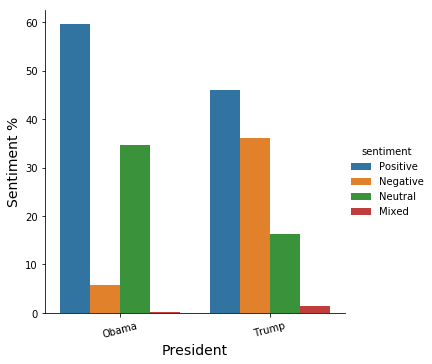

In [34]:
#plotting the results
sns_plot = sns.factorplot(x='label_capitalized', y='sentiment_perc', hue='sentiment', data=df_melt, kind='bar')
sns_plot.set_xticklabels(rotation=15)
sns_plot.set_xlabels('President', fontsize=14)
sns_plot.set_ylabels('Sentiment %', fontsize=14)
sns_plot.set_titles('Sentiment Analysis')
plt.show()


In [35]:
# transforming the dataframe to another format
df_t = df_sentiment.drop('label_capitalized', axis=1).T
df_t = df_t.reindex(index = ['Positive', 'Neutral', 'Negative', 'Mixed'])
df_t

,obama,trump
Positive,0.595635,0.460948
Neutral,0.345550,0.162560
Negative,0.057552,0.361498
Mixed,0.001390,0.015020


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


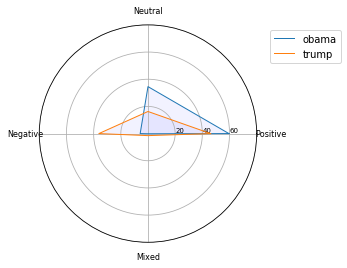

In [37]:
# spider chart visualisation
categories=['Positive', 'Neutral', 'Negative', 'Mixed']
colors = ['']
N = len(categories)
legend = []

for n in range(len(df_t.columns)):

    values= df_t[df_t.columns[n]].tolist()
    values += values[:1]
    legend.append(df_t.columns[n])
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)

    plt.xticks(angles[:-1], categories, color='black', size=8)

    
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6, 0.8], ["20","40","60", ""], color="black", size=7)
    plt.ylim(0,0.80)

    
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    

    plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left")
    ax.fill(angles, values, 'b', alpha=0.05)

plt.show()
    

things to go on with:
    - download the original audio transcription and compare it with the aws comprehend (spacy, wmd)
    - use other sentiment analyis tools (vader for example)
    - more graphs